In [1]:
%matplotlib inline

import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import warnings
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm
from typing import List, Optional
import glob
from pathlib import Path

from facemesh import FaceMeshBlock, FaceMesh
from pupil_detection import IrisLM, IrisBlock
from util_funcs import pad_image
from face_detector import FaceDetector

warnings.filterwarnings('ignore')
tqdm.pandas()

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [4]:
pretrained_model_face = FaceMesh()
pretrained_model_face.load_weights("./weights/facemesh.pth")

model_path = "./weights/irislandmarks.pth"
pretrained_model_eyes = IrisLM()
weights = torch.load(model_path)
pretrained_model_eyes.load_state_dict(weights)

<All keys matched successfully>

In [5]:
class FaceGridModel(nn.Module):
    def __init__(self, gridSize = 25):
        super(FaceGridModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(gridSize * gridSize, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
class EyesModel(nn.Module):
    def __init__(self, pretrained_model_eyes: nn.Module):
        super(EyesModel, self).__init__()
        self.backbone = pretrained_model_eyes.backbone
        self.regression_head_eyes = nn.Sequential(
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
        )
        # connect eyes
        self.fc = nn.Sequential(
            nn.Linear(2 * 128 * 1 * 1, 128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_eye_l, x_eye_r):
        x_eye_l = self.backbone(x_eye_l)
        x_eye_l = self.regression_head_eyes(x_eye_l)
        x_eye_l = x_eye_l.view(-1, 128 * 1 * 1)

        x_eye_r = self.backbone(x_eye_r)
        x_eye_r = self.regression_head_eyes(x_eye_r)
        x_eye_r = x_eye_r.view(-1, 128 * 1 * 1)
        x = torch.cat([x_eye_l, x_eye_r], 1)
        x = self.fc(x)
        return x

In [7]:
class FaceModel(nn.Module):
    def __init__(self, pretrained_model_face: nn.Module):
        super(FaceModel, self).__init__()
        self.backbone = pretrained_model_face.backbone
        self.regression_head_face = nn.Sequential(
            FaceMeshBlock(128, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
            nn.Conv2d(128, 32, 1),
            nn.PReLU(32),
            FaceMeshBlock(32, 32),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
        )

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0

    def forward(self, x_face):
        x_face = self._preprocess(x_face)
        x_face = nn.ReflectionPad2d((1, 0, 1, 0))(x_face)
        x_face = self.backbone(x_face)
        x_face = self.regression_head_face(x_face)
        x_face = x_face.view(-1, 32 * 3 * 3)
        x = self.fc(x_face)
        return x

In [8]:
class FineTuneModel(nn.Module):
    def __init__(
        self,
        pretrained_model_face: nn.Module,
        pretrained_model_eyes: nn.Module,
        screen_features: bool = False,
    ):
        super(FineTuneModel, self).__init__()
        self.face_model = FaceModel(pretrained_model_face)
        self.eyes_model = EyesModel(pretrained_model_eyes)
        self.face_grid_model = FaceGridModel()
        self.screen_features = screen_features
        if not screen_features:
            self.fc = nn.Sequential(
                nn.Linear(128+64+128, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
            )
        else:
            self.fc1 = nn.Sequential(
                nn.Linear(128+64+128, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 13),
                nn.ReLU(inplace=True),
            )
            self.layer_norm = nn.LayerNorm(16)
            self.fc2 = nn.Linear(16, 2)
            

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0
        
    def forward(self, x_face, x_eye_l, x_eye_r, x_grid, x_screen = None):
        if self.screen_features and x_screen is None:
            raise Exception("You should pass screen features")
        if not self.screen_features and x_screen is not None:
            warnings.warn("Screen fearures won't be used")
        x_eyes = self.eyes_model(x_eye_l, x_eye_r)
        x_face = self.face_model(x_face)
        x_grid = self.face_grid_model(x_grid)
        x = torch.cat([x_eyes, x_face, x_grid], axis = 1)
        if not self.screen_features:
            x = self.fc(x)
        else:
            x = self.fc1(x)
            x = torch.cat([x, x_screen], axis = 1)
            x = self.layer_norm(x)
            x = self.fc2(x)
        return x

In [9]:
screen_feat = np.array([[33.17, 20.73, 54.0], [33.17, 20.73, 54.0]])
screen_feat = torch.tensor((screen_feat - screen_feat.mean()) / screen_feat.std()).type(torch.float32).to(device)
screen_feat

tensor([[-0.20376, -1.11009,  1.31384],
        [-0.20376, -1.11009,  1.31384]], device='cuda:0')

In [10]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes, screen_features = True).to(device)

In [11]:
rand_img = np.random.randint(0, 255, (2, 3, 192,192))
x_face = torch.from_numpy(rand_img).to(device)
rand_img = (np.random.randint(0, 255, (2, 3, 64, 64)) / 255.)
x_eye = torch.from_numpy(rand_img).type(torch.float32).to(device)
rand_grid = (np.random.randint(0, 255, (2, 25, 25)) / 255.)
x_grid = torch.from_numpy(rand_grid).type(torch.float32).to(device)

In [12]:
model(x_face, x_eye, x_eye, x_grid, screen_feat)

tensor([[-0.18822,  0.75986],
        [-0.22484,  0.63052]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [2]:
def get_screen_specs(df: pd.DataFrame):
    user_specs_path = "../data/participant_characteristics.csv"
    user_specs = pd.read_csv(user_specs_path)[[
        'Participant ID', 'Screen Width (cm)', 'Screen Height (cm)',
        'Distance From Screen (cm)'
    ]]
    fill_dict = user_specs.groupby("Screen Width (cm)")["Distance From Screen (cm)"].median().to_dict()
    user_specs["Distance From Screen (cm)"] = \
            user_specs["Distance From Screen (cm)"].fillna(user_specs["Screen Width (cm)"].map(fill_dict))
    df["user_id"] = df["full_name"].apply(lambda x: x.split("#")[0])
    df = df.merge(
        user_specs, left_on = "user_id",
        right_on = 'Participant ID',
        how = "inner"
    ).drop(columns = ['Participant ID'])
    return df

In [3]:
data = pd.read_csv("./tobii_full_pred_final_updv2.csv")

In [4]:
data = get_screen_specs(data)

In [6]:
data[['Screen Width (cm)', 'Screen Height (cm)']].value_counts()

Screen Width (cm)  Screen Height (cm)
51.70              32.31                 444044
33.17              20.73                 233146
Name: count, dtype: int64

In [20]:
data.head()

,paths,x_normalized,y_normalized,full_name,pred_x,pred_y,user_id,Screen Width (cm),Screen Height (cm),Distance From Screen (cm)
0,/home/ubuntu/projects/tweakle/data/tobii_image...,0.400634,0.371580,P_15#1491933738937_2_-study-dot_test_instructi...,0.227233,0.248519,P_15,33.17,20.73,54.0
1,/home/ubuntu/projects/tweakle/data/tobii_image...,0.402445,0.382982,P_15#1491933738937_2_-study-dot_test_instructi...,0.207957,0.255719,P_15,33.17,20.73,54.0
2,/home/ubuntu/projects/tweakle/data/tobii_image...,0.403391,0.378205,P_15#1491933738937_2_-study-dot_test_instructi...,0.191822,0.256179,P_15,33.17,20.73,54.0
3,/home/ubuntu/projects/tweakle/data/tobii_image...,0.401790,0.382480,P_15#1491933738937_2_-study-dot_test_instructi...,0.289968,0.198733,P_15,33.17,20.73,54.0
4,/home/ubuntu/projects/tweakle/data/tobii_image...,0.401127,0.379053,P_15#1491933738937_2_-study-dot_test_instructi...,0.300984,0.192523,P_15,33.17,20.73,54.0


In [11]:
# data["x_normalized"] = (data["tob_right_x"] + data["tob_left_x"]) / 2
# data["y_normalized"] = (data["tob_right_y"] + data["tob_left_y"]) / 2

In [12]:
# import os
# data["paths"] = data["full_name"].apply(lambda x: f"/home/ubuntu/projects/tweakle/data/tobii_images/{x}")
# data["paths"].head()

0    /home/ubuntu/projects/tweakle/data/tobii_image...
1    /home/ubuntu/projects/tweakle/data/tobii_image...
2    /home/ubuntu/projects/tweakle/data/tobii_image...
3    /home/ubuntu/projects/tweakle/data/tobii_image...
4    /home/ubuntu/projects/tweakle/data/tobii_image...
Name: paths, dtype: object

In [14]:
class EyesExtractor:
    def __init__(
        self,
        save_folder: Optional[str] = None,
        facemesh_weights: str = "./weights/facemesh.pth",
        device: str = "cpu"
    ):
        self.facemesh =  FaceMesh().to(device)
        self.facemesh.load_weights(facemesh_weights)
        self.left_eye_indices = [33, 7, 163, 144, 145, 153, 154, 155,
                                 246, 161, 160, 159, 158, 157, 173, 133]
        self.right_eye_indices = [249, 263, 362, 373, 374, 380, 381, 382,
                                  384, 385, 386, 387, 388, 390, 398, 466]

    def get_eye_crop(self, points: np.array, img: np.array, which_eye: str):
        h, w, _ = img.shape
        sorted_point_x = sorted(points, key = lambda x: x[0])
        sorted_point_y = sorted(points, key = lambda x: x[1])
        left_point = sorted_point_x[0]
        right_point = sorted_point_x[-1]
        up_point = sorted_point_y[0]
        down_point = sorted_point_y[-1]
        multiplicator = 1/2
        margin_x_left = max(64 - (right_point[0] - left_point[0]), 0) * multiplicator
        margin_x_right = max(64 - (right_point[0] - left_point[0]), 0) * (1 - multiplicator)
        margin_y = max(64 - (down_point[1] - up_point[1]), 0) / 2
        min_x, max_x = max(0, int(left_point[0] - margin_x_left)), min(w, int(right_point[0] + margin_x_right))
        min_y, max_y = max(0, int(up_point[1] - margin_y)), min(h, int(down_point[1] + margin_y))
        img_eye = img[min_y: max_y, min_x: max_x, :]
        left_top_point = (min_x, min_y) 
        return img_eye, left_top_point


    def extract_eyes(self, face_crop: np.ndarray):
        face_crop = cv2.resize(face_crop, (192, 192), interpolation = cv2.INTER_LINEAR)
        face_crop = cv2.flip(face_crop, 1)
        facemesh_points = self.facemesh.predict_on_image(face_crop).cpu().numpy()
        left_eye_points = facemesh_points[self.left_eye_indices]
        right_eye_points = facemesh_points[self.right_eye_indices]
        img_eye_left, _ = self.get_eye_crop(left_eye_points, face_crop, which_eye = "left")
        img_eye_right, _ = self.get_eye_crop(right_eye_points, face_crop, which_eye = "right")
        return img_eye_left, img_eye_right

In [15]:
class GazeDetectionDataset(Dataset):
    """Gaze detection dataset."""

    def __init__(
        self,
        data: pd.DataFrame,
        transform_list: Optional[List]= None,
        to_tensors: bool = False,
        device: str = "cpu",
        inference: bool = False,
        screen_features: bool = False,
        precompute_folder: str = "./data_precompute"
    ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data.copy()
        self.to_tensors = to_tensors
        transform_list_ = transform_list.copy()
        if to_tensors:
            transform_list_.append(ToTensorV2())
        transform_list_eyes = []
        if to_tensors:
            transform_list_eyes.append(ToTensorV2())
        self.transform = A.Compose(transform_list_)
        self.transform_eyes = A.Compose(transform_list_eyes)
        transform_list_mask = [A.Resize(25, 25)]
        if to_tensors:
            transform_list_mask.append(ToTensorV2())
        self.transform_mask = A.Compose(transform_list_mask)
        self.device = torch.device(device)
        self.faceCascade = cv2.CascadeClassifier("./weights/haarcascade_frontalface_alt.xml")
        self.eyesExtractor = EyesExtractor(device = device)
        self.inference = inference
        if device != "cpu":
            device = str(0)
        self.face_detector = FaceDetector(device = device)
        self.screen_features = screen_features
        self.precompute_folder = precompute_folder
        if not os.path.exists(precompute_folder):
            os.mkdir(precompute_folder)
            os.mkdir(os.path.join(precompute_folder, "faces"))
            os.mkdir(os.path.join(precompute_folder, "eyes"))
            os.mkdir(os.path.join(precompute_folder, "bboxes"))


    def get_face_mask(self, frame, face_rect):
        mask = np.zeros((frame.shape[0], frame.shape[1]))
        if face_rect is None:
            return mask
        mask[
            face_rect[1] : face_rect[1] + face_rect[3],
            face_rect[0] : face_rect[0] + face_rect[2]
        ] = 1
        return mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        img_path = row['paths']
        try:
            image_orig = cv2.imread(img_path)
            image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
            img_path_ = Path(img_path)
            face_path = os.path.join(self.precompute_folder, "faces", img_path_.name)
            face_rect_path = face_path.replace("faces", "bboxes").replace(".png", ".npy")
            if not os.path.exists(face_path):
                image, face_rect = self.face_detector.detect_face(img_path)
                cv2.imwrite(face_path, image)
                np.save(face_rect_path, np.array(face_rect))
            else:
                try:
                    image = cv2.imread(face_path)
                    face_rect = np.load(face_rect_path, allow_pickle=True)
                    if face_rect.dtype.__str__() == "object":
                        face_rect = None
                except Exception:
                    image, face_rect = self.face_detector.detect_face(img_path)
                    cv2.imwrite(face_path, image)
                    np.save(face_rect_path, np.array(face_rect))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            face_mask = self.get_face_mask(image_orig, face_rect)
            eyes_path_l = face_path.replace("faces", "eyes").replace(".png", "_left.png")
            eyes_path_r = face_path.replace("faces", "eyes").replace(".png", "_right.png")
            if not os.path.exists(eyes_path_l):
                image_eye_l, image_eye_r = self.eyesExtractor.extract_eyes(image)
                image_eye_l_ = cv2.cvtColor(image_eye_l, cv2.COLOR_RGB2BGR)
                image_eye_r_ = cv2.cvtColor(image_eye_r, cv2.COLOR_RGB2BGR)
                cv2.imwrite(eyes_path_l, image_eye_l_)
                cv2.imwrite(eyes_path_r, image_eye_r_)
            else:
                try:
                    image_eye_l = cv2.imread(eyes_path_l)
                    image_eye_l = cv2.cvtColor(image_eye_l, cv2.COLOR_BGR2RGB)
                    image_eye_r = cv2.imread(eyes_path_r)
                    image_eye_r = cv2.cvtColor(image_eye_r, cv2.COLOR_BGR2RGB)
                except Exception:
                    image_eye_l, image_eye_r = self.eyesExtractor.extract_eyes(image)
                    image_eye_l_ = cv2.cvtColor(image_eye_l, cv2.COLOR_RGB2BGR)
                    image_eye_r_ = cv2.cvtColor(image_eye_r, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(eyes_path_l, image_eye_l_)
                    cv2.imwrite(eyes_path_r, image_eye_r_)
            image = image / 255.
            image_eye_l = image_eye_l / 255.
            image_eye_r = image_eye_r / 255.
        except Exception:
            raise Exception(f"Image {img_path}, {eye_left_path} failed loading")
        if not self.inference:
            coordinates = row[['x_normalized', 'y_normalized']].values.astype(np.float32)
        if self.screen_features:
            screen_feat = row[[
                'Screen Width (cm)',
                'Screen Height (cm)',
                'Distance From Screen (cm)'
            ]].values.astype(np.float32)
            screen_feat = (screen_feat - screen_feat.mean()) / screen_feat.std()
        
        if self.transform:
            image = self.transform(image = image)['image']
            face_mask = self.transform_mask(image = face_mask)['image']
            image_eye_l = self.transform_eyes(image = image_eye_l)['image']
            image_eye_r = self.transform_eyes(image = image_eye_r)['image']
            if self.to_tensors:
                if not self.inference:
                    coordinates = torch.from_numpy(coordinates).to(self.device)
                if self.screen_features:
                    screen_feat = torch.from_numpy(screen_feat).to(self.device)
                image = image.type(torch.float32).to(self.device)
                image_eye_l = image_eye_l.type(torch.float32).to(self.device)
                image_eye_r = image_eye_r.type(torch.float32).to(self.device)
                face_mask = face_mask.type(torch.float32).to(self.device)
            
        sample = {'image': image, "eye_l": image_eye_l,
                  "eye_r": image_eye_r, "face_mask": face_mask}
        if not self.inference:
            sample['coordinates'] = coordinates
        if self.screen_features:
            sample['screen_features'] = screen_feat
        return sample

In [16]:
trans_list = [
        A.Resize(192, 192),
        # ToTensorV2()
    ]

Fusing layers... 
0 (192, 192, 3) (2,) (3,)


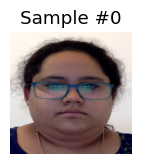

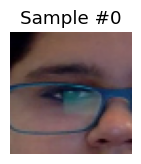

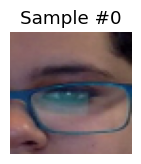

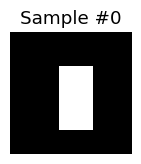

1 (192, 192, 3) (2,) (3,)


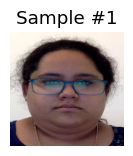

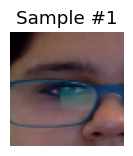

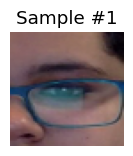

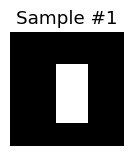

2 (192, 192, 3) (2,) (3,)


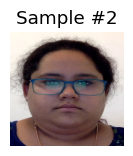

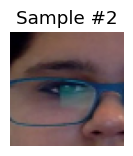

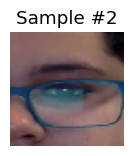

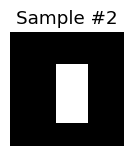

3 (192, 192, 3) (2,) (3,)


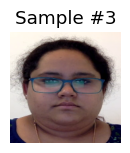

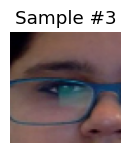

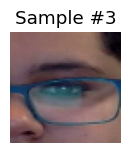

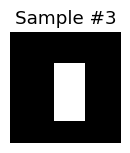

In [29]:
face_dataset = GazeDetectionDataset(data=data.tail(100), transform_list=trans_list, screen_features=True)

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(
        i, 
        sample['image'].shape, 
        sample['coordinates'].shape, 
        sample['screen_features'].shape
    )

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['image'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_l'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_r'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['face_mask'], cmap = "gray")
    plt.show()
    if i == 3:
        plt.show()
        break

In [31]:
face_dataset = GazeDetectionDataset(data = data, transform_list=trans_list, to_tensors=True, device=device, screen_features=True)

Fusing layers... 


In [32]:
for i, sample in enumerate(face_dataset):
    print(i,
          sample['image'].size(), 
          sample['coordinates'].size(), 
          sample['eye_l'].size(), 
          sample['face_mask'].size(),
          sample['screen_features'].size(),
         )
    if i == 3:
        break

0 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25]) torch.Size([3])
1 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25]) torch.Size([3])
2 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25]) torch.Size([3])
3 torch.Size([3, 192, 192]) torch.Size([2]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25]) torch.Size([3])


In [17]:
def train(model: FineTuneModel, dataloader_train: DataLoader):
    total_loss = 0.0
    model.train()
    preds_list = []
    labels_list = []
    for i, data in enumerate(dataloader_train):
        inputs, labels, inputs_eye_l, inputs_eye_r, inputs_mask, inputs_screen = data['image'], data['coordinates'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask'], data['screen_features']

        optimizer.zero_grad()

        outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask, inputs_screen)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        preds_list += outputs.cpu().detach().tolist()
        labels_list += labels.cpu().detach().tolist()
        total_loss += loss.cpu().item()

    loss = total_loss / (i + 1)
    mape_value = mape(labels_list, preds_list)
    return loss, mape_value

In [18]:
def eval(model: FineTuneModel, dataloader_val: DataLoader):
    total_loss = 0.0
    model.eval()
    preds = []
    preds_list = []
    labels_list = []
    for i, data in enumerate(dataloader_val):
        inputs, labels, inputs_eye_l, inputs_eye_r, inputs_mask, inputs_screen = data['image'], data['coordinates'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask'], data['screen_features']
        with torch.no_grad():
            outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask, inputs_screen)
        loss = criterion(outputs, labels)
        total_loss += loss.cpu().item()
        preds_list += outputs.cpu().detach().tolist()
        labels_list += labels.cpu().detach().tolist()
        
    loss = total_loss / (i + 1)
    mape_value = mape(labels_list, preds_list)
    return loss, mape_value

In [19]:
from sklearn.model_selection import train_test_split

In [9]:
# data = pd.read_csv("../data/data_clicks.csv")

In [24]:
df = pd.read_csv("./tobii_full_pred_final_updv2.csv")

In [74]:
# df_sub = df.sample(100_000)

In [11]:
# df["x_normalized"] = (df["tob_right_x"] + df["tob_left_x"]) / 2
# df["y_normalized"] = (df["tob_right_y"] + df["tob_left_y"]) / 2

In [12]:
# import os
# df["paths"] = df["full_name"].apply(lambda x: f"/home/ubuntu/projects/tweakle/data/tobii_images/{x}")
# df["paths"].head()

In [20]:
NUM_SAMPLES = None
BATCH_SIZE = 1024
LEARNING_RATE = 3e-4
REDUCE_FACTOR = 0.5
PATIENCE = 2
NUM_EPOCHS = 25
WEIGHT_DECAY = 1e-4
CHECKPOINTS_PATH = "./checkpoints/"
EXPERIMENT_NAME = "face_eyes_mask_screen_feat_correctedv2_balanced"

In [45]:
# train_df, test_df = train_test_split(df.head(NUM_SAMPLES), test_size = 14000, random_state=42, shuffle=True)
# train_df, val_df = train_test_split(train_df, test_size = 7000, random_state=42, shuffle=True)

In [46]:
# test_df.to_csv("./tobii_test_full.csv", index = False)
# val_df.to_csv("./tobii_val_full.csv", index = False)
# train_df.to_csv("./tobii_train_full.csv", index = False)

In [7]:
test_df = pd.read_csv("./tobii_test_full.csv").drop(columns = ["pred_x", "pred_y"])
val_df = pd.read_csv("./tobii_val_full.csv").drop(columns = ["pred_x", "pred_y"])
train_df = pd.read_csv("./tobii_train_full_balanced.csv").drop(columns = ["pred_x", "pred_y"])

In [8]:
test_df = get_screen_specs(test_df)
val_df = get_screen_specs(val_df)
train_df = get_screen_specs(train_df)

In [9]:
train_df[['Screen Width (cm)', 'Screen Height (cm)']].value_counts()

Screen Width (cm)  Screen Height (cm)
51.70              32.31                 51208
33.17              20.73                 32318
Name: count, dtype: int64

In [23]:
train_df.shape

(83526, 8)

In [24]:
val_df.shape

(7000, 8)

In [25]:
test_df.shape

(14000, 8)

In [47]:
# def try_load(img_path):
#     try:
#         eyes_path = img_path.replace("tobii_images", "eyes_images")
#         eye_left_path = eyes_path.replace(".png", "_left.png")
#         image_eye_l = cv2.imread(eye_left_path)
#         image_eye_l = cv2.cvtColor(image_eye_l, cv2.COLOR_BGR2RGB) / 255.
#         return True
#     except:
#         return False

In [48]:
# test_df["eyes_exist"] = test_df.paths.apply(try_load)
# val_df["eyes_exist"] = val_df.paths.apply(try_load)
# train_df["eyes_exist"] = train_df.paths.apply(try_load)

In [49]:
# test_df = test_df[test_df["eyes_exist"]]
# val_df = val_df[val_df["eyes_exist"]]
# train_df = train_df[train_df["eyes_exist"]]

In [59]:
dataset_train = GazeDetectionDataset(data = train_df, transform_list=trans_list,
                                     to_tensors=True, device=device, screen_features=True)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)
dataset_val = GazeDetectionDataset(data = val_df, transform_list=trans_list,
                                   to_tensors=True, device=device, screen_features=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

Fusing layers... 
Fusing layers... 


In [26]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [61]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="4qtNKAjcucKnOrwC4pRvPaHRv",
  project_name="tweakle-gaze-detection",
  workspace="kmisterios"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kmisterios/tweakle-gaze-detection/0c18af1dbbd743b594e3446544ed592c
COMET INFO:   Others:
COMET INFO:     Name : face_eyes_mask_screen_feat_correctedv2_balanced
COMET INFO:   Parameters:
COMET INFO:     batch_size      : 1024
COMET INFO:     experiment_name : face_eyes_mask_screen_feat_correctedv2_balanced
COMET INFO:     gradient_clip   : True
COMET INFO:     learning_rate   : 0.0003
COMET INFO:     num_epochs      : 25
COMET INFO:     num_samples     : 1
COMET INFO:     optimizer       : Adam (
Parameter Group 0
  

In [62]:
experiment.set_name(f"{EXPERIMENT_NAME}")

In [63]:
# model = FineTuneModel(pretrained_model_face, pretrained_model_eyes, screen_features=True).to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, factor= REDUCE_FACTOR, patience=PATIENCE)

In [64]:
hyper_params = {
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "reduce_factor": REDUCE_FACTOR,
    "patience": PATIENCE,
    "num_epochs": NUM_EPOCHS,
    "num_samples": NUM_SAMPLES,
    "optimizer": optimizer.__str__(),
    "scheduler": scheduler.__str__(),
    "gradient_clip": True,
    "experiment_name": EXPERIMENT_NAME
}
experiment.log_parameters(hyper_params)

In [65]:
val_loss_min = np.inf
epoch_save = None

for epoch in range(NUM_EPOCHS):
    train_loss, train_mape = train(model, dataloader_train)
    val_loss, val_mape = train(model, dataloader_val)
    scheduler.step(val_loss)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    if val_loss_min > val_loss:
        val_loss_min = val_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt"))
        epoch_save = epoch

    print()
    print(f'Epoch: {epoch}: Train loss: {round(train_loss, 3)}; Val loss: {round(val_loss, 3)};')
    if epoch_save is not None:
        print(f'Best model saved on epoch {epoch_save}')
    experiment.log_metrics({
        "rmse_val": val_loss,
        "rmse_train": train_loss,
        "best_model_epoch": epoch_save,
        "train_mape": train_mape,
        "val_mape": val_mape,
        "epoch": epoch,
        "lr": current_lr
    })
experiment.end()

libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 0: Train loss: 0.137; Val loss: 0.127;
Best model saved on epoch 0


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 1: Train loss: 0.128; Val loss: 0.132;
Best model saved on epoch 0


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 2: Train loss: 0.126; Val loss: 0.126;
Best model saved on epoch 2


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 3: Train loss: 0.126; Val loss: 0.13;
Best model saved on epoch 2


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 4: Train loss: 0.126; Val loss: 0.126;
Best model saved on epoch 4


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 5: Train loss: 0.123; Val loss: 0.126;
Best model saved on epoch 4


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 6: Train loss: 0.122; Val loss: 0.123;
Best model saved on epoch 6


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 7: Train loss: 0.12; Val loss: 0.12;
Best model saved on epoch 7


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 8: Train loss: 0.12; Val loss: 0.123;
Best model saved on epoch 7


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 9: Train loss: 0.119; Val loss: 0.12;
Best model saved on epoch 7


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 10: Train loss: 0.119; Val loss: 0.127;
Best model saved on epoch 7


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 11: Train loss: 0.115; Val loss: 0.118;
Best model saved on epoch 11


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 12: Train loss: 0.114; Val loss: 0.119;
Best model saved on epoch 11


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 13: Train loss: 0.114; Val loss: 0.119;
Best model saved on epoch 11


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 14: Train loss: 0.114; Val loss: 0.118;
Best model saved on epoch 14


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 15: Train loss: 0.113; Val loss: 0.117;
Best model saved on epoch 15


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 16: Train loss: 0.112; Val loss: 0.118;
Best model saved on epoch 15


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 17: Train loss: 0.112; Val loss: 0.118;
Best model saved on epoch 15


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 18: Train loss: 0.111; Val loss: 0.117;
Best model saved on epoch 15


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 19: Train loss: 0.11; Val loss: 0.116;
Best model saved on epoch 19


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 20: Train loss: 0.11; Val loss: 0.115;
Best model saved on epoch 20


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 21: Train loss: 0.109; Val loss: 0.115;
Best model saved on epoch 21


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 22: Train loss: 0.109; Val loss: 0.114;
Best model saved on epoch 22


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data



Epoch: 23: Train loss: 0.109; Val loss: 0.114;
Best model saved on epoch 22


libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kmisterios/tweakle-gaze-detection/2cc7df2a582e438b885d28f9949e673a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     best_model_epoch [25] : (0, 22)
COMET INFO:    


Epoch: 24: Train loss: 0.108; Val loss: 0.116;
Best model saved on epoch 22


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


In [27]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes, screen_features=True).to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt")))
# model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_raw_images.pt")))
criterion = RMSELoss()
model.eval()

FineTuneModel(
  (face_model): FaceModel(
    (backbone): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): PReLU(num_parameters=16)
      (2): FaceMeshBlock(
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
          (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (act): PReLU(num_parameters=16)
      )
      (3): FaceMeshBlock(
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
          (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (act): PReLU(num_parameters=16)
      )
      (4): FaceMeshBlock(
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16)
          (1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
   

In [28]:
dataset_test = GazeDetectionDataset(data = test_df, transform_list=trans_list, to_tensors=True, device=device, screen_features=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

Fusing layers... 


In [29]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_test), total = len(dataloader_test)):
    inputs, labels, inputs_eye_l, inputs_eye_r, inputs_mask, inputs_screen = data['image'], data['coordinates'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask'], data['screen_features']
    with torch.no_grad():
        outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask, inputs_screen)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

  0%|                                                    | 0/14 [00:00<?, ?it/s]libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data
100%|███████████████████████████████████████████| 14/14 [09:36<00:00, 41.15s/it]

Test loss: 0.117


In [30]:
print(f"Test loss: {round(losses / (i + 1), 3)}")

Test loss: 0.117


In [31]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [32]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.45024290680885315


In [33]:
test_df_copy = test_df.copy()

In [34]:
test_df_copy["pred_x"] = preds.T[0]
test_df_copy["pred_y"] = preds.T[1]

In [35]:
test_df_copy[['x_normalized', 'y_normalized', 'pred_x', 'pred_y']].tail(40)

,x_normalized,y_normalized,pred_x,pred_y
13960,0.289531,0.447940,0.315406,0.444950
13961,0.186415,0.411102,0.351822,0.669539
13962,0.366938,0.551427,0.399667,0.605237
13963,0.769112,0.503062,0.584475,0.391746
13964,0.374805,0.733435,0.535983,0.727726
13965,0.590999,0.256828,0.530169,0.593757
13966,0.472062,0.809387,0.398535,0.687643
13967,0.270549,0.556352,0.232675,0.466458
13968,0.473201,0.522423,0.386055,0.535691
13969,0.138919,0.538875,0.195119,0.569630


In [36]:
test_df_copy.to_csv("./tobii_test_updv2_mixed_face_screen_feat_balanced_pred.csv", index = False)

In [42]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_val), total = len(dataloader_val)):
    inputs, labels = data['image'], data['coordinates']
    with torch.no_grad():
        outputs = model(inputs)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

100%|█████████████████████████████████████████████| 9/9 [01:20<00:00,  8.95s/it]

Test loss: 0.175


In [122]:
print(f"Val loss: {round(losses / (i + 1), 3)}")

NameError: name 'losses' is not defined

In [44]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [45]:
mape_value = mape(labels, preds)
print(f"Val MAPE: {mape_value}")

Val MAPE: 0.4815107583999634


In [50]:
rmse_value = mse(labels, preds, squared=True)
print(f"Val RMSE: {rmse_value}")

Val RMSE: 0.030162379145622253


In [46]:
val_df_copy = val_df.copy()

In [47]:
val_df_copy["pred_x"] = preds.T[0]
val_df_copy["pred_y"] = preds.T[1]

In [54]:
test1 = val_df_copy[(val_df_copy["x_normalized"] < 1.2) & (val_df_copy["y_normalized"] < 1.1)]
condition = ((test1["x_normalized"] > 0.6) & (test1["pred_x"] < 0.4)) | \
            ((test1["x_normalized"] < 0.4) & (test1["pred_x"] > 0.6))
test2 = test1[~condition]

In [55]:
preds = test2[["pred_x", "pred_y"]].values
labels = test2[["x_normalized", "y_normalized"]].values

In [56]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.8610942596087398


In [57]:
rmse_value = mse(labels, preds, squared=True)
print(f"Test RMSE: {rmse_value}")

Test RMSE: 0.047016402471560886


In [58]:
test2.drop(columns = ["pred_x", "pred_y"]).to_csv("./tobii_val_sub_updv2.csv", index = False)

In [59]:
preds = []
labels_list = []
losses = 0
for i, data in tqdm(enumerate(dataloader_train), total = len(dataloader_train)):
    inputs, labels = data['image'], data['coordinates']
    with torch.no_grad():
        outputs = model(inputs)
    loss = criterion(outputs, labels)
    losses += loss.detach().cpu().item()
    pred = outputs.cpu().numpy()
    preds.append(pred)
    labels_list.append(labels.cpu().numpy())

print(f"Test loss: {round(losses / (i + 1), 3)}")

100%|███████████████████████████████████████████| 75/75 [12:09<00:00,  9.73s/it]

Test loss: 0.166


In [121]:
print(f"Val loss: {round(losses / (i + 1), 3)}")

NameError: name 'losses' is not defined

In [61]:
preds = np.vstack(preds)
labels = np.vstack(labels_list)

In [62]:
mape_value = mape(labels, preds)
print(f"Val MAPE: {mape_value}")

Val MAPE: 0.4815669059753418


In [63]:
rmse_value = mse(labels, preds, squared=True)
print(f"Val RMSE: {rmse_value}")

Val RMSE: 0.02777956984937191


In [64]:
train_df_copy = train_df.copy()

In [65]:
train_df_copy["pred_x"] = preds.T[0]
train_df_copy["pred_y"] = preds.T[1]

In [66]:
test1 = train_df_copy[(train_df_copy["x_normalized"] < 1.2) & (train_df_copy["y_normalized"] < 1.1)]
condition = ((test1["x_normalized"] > 0.6) & (test1["pred_x"] < 0.4)) | \
            ((test1["x_normalized"] < 0.4) & (test1["pred_x"] > 0.6))
test2 = test1[~condition]

In [67]:
preds = test2[["pred_x", "pred_y"]].values
labels = test2[["x_normalized", "y_normalized"]].values

In [68]:
mape_value = mape(labels, preds)
print(f"Test MAPE: {mape_value}")

Test MAPE: 0.8352110407623952


In [69]:
rmse_value = mse(labels, preds, squared=True)
print(f"Test RMSE: {rmse_value}")

Test RMSE: 0.0466036837919723


In [70]:
test2.drop(columns = ["pred_x", "pred_y"]).to_csv("./tobii_train_sub_updv2.csv", index = False)